In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import sem, mannwhitneyu, iqr, ttest_ind, describe
from scipy.signal import savgol_filter, hamming, find_peaks
from sklearn.model_selection import train_test_split, KFold
from sklearn.decomposition import PCA 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.neighbors import KernelDensity as kde
from sklearn.feature_selection import mutual_info_classif
from sklearn.inspection import permutation_importance
from datetime import datetime as dt
import csv
import Raman_tools as rt

import sys
sys.path.append('/Users/pinguino/Documents/ENSO')
import ENSO_ccn as nn
import ENSOutils as utils

sys.path.append('/Users/pinguino/Documents/Deconvnet_CRP')
import ICUAI_OCM as ocm

import tensorflow as tf
tf.random.set_seed(28)
import tensorflow.keras.backend as K



####
def prepeare_data(X1, X2, nbands= 16):
    X = np.vstack([X1, X2])
    X = rt.savgol_filt(X) ##apply savgol filter
    X = rt.meanpooling_trasform(X, size= int(X.shape[1]/nbands))
    Y = np.hstack([np.zeros(X1.shape[0]), np.ones(X2.shape[0])])
    return X, Y

def prepeare_data_standard(X1, X2):
    X = np.vstack([X1, X2])
    X = rt.savgol_filt(X) ##apply savgol filter
    Y = np.hstack([np.zeros(X1.shape[0]), np.ones(X2.shape[0])])
    return X, Y


def univariate_auc(x0, x1):
    
    # compute the AUC via U-test
    # x0--> data class0, x1 --> data class1
    n1, n2 = x0.shape[0], x1.shape[0]
    stat_, pval_ = mannwhitneyu(x1, x0)
    return stat_/(n1*n2)
    
#savepath = 'imgs_diana_apr_2022'

def softplus(X):
    return np.log(1+np.exp(X))

type_chunk= 'metilation'

In [2]:
#### IMPORT DATA
###
path1 = 'diana-dati-tumorali_lug2022/colon_luglio2022/Hacat_terzo set.dat'
ld1 = pd.read_csv(path1, sep = '\t', index_col=False, decimal=',')
###
path2 = 'diana-dati-tumorali_lug2022/melanoma_luglio2022/202207-A375.dat'
ld2 = pd.read_csv(path2, sep = '\t', index_col=False)
###
path3 = 'diana-dati-tumorali_lug2022/melanoma_luglio2022/202207-SkMel28.dat'
ld3 = pd.read_csv(path3, sep = '\t', index_col=False)
###
path4 = 'diana-dati-tumorali_lug2022/colon_luglio2022/Ht29_terzo set.dat'
ld4 = pd.read_csv(path4, sep = '\t', index_col=False, decimal= ',')
###
path5 = 'diana-dati-tumorali_lug2022/colon_luglio2022/CaCO_terzo set.dat'
ld5 = pd.read_csv(path5, sep = '\t', index_col=False, decimal=',')


########## load data - 1st region - peak 200cm^-1
xx1 = ld1.values[726:1479, 2:].T 
xx2 = ld2.values[726:1479, 2:].T
xx3 = ld3.values[726:1479, 2:].T
xx4 = ld4.values[726:1479, 2:].T
xx5 = ld5.values[726:1479, 2:].T
inverse_wavelenght = ld1.values[726:1479, 1]

#### #### #### #### ### #### ####
### Skimming the data, remove spectra whose wavelenghts show at least one outlier intensity. 
xx1 = rt.skim_instances(xx1, standardize=False)
xx2 = rt.skim_instances(xx2, standardize=False)
xx3 = rt.skim_instances(xx3, standardize=False)
xx4 = rt.skim_instances(xx4, standardize=False)
xx5 = rt.skim_instances(xx5, standardize=False)

###resort data respect to the inverse_wavelenght
new_indexing = np.argsort(inverse_wavelenght)
inverse_wavelenght = inverse_wavelenght[new_indexing]
xx1 = xx1[:, new_indexing]
xx2 = xx2[:, new_indexing]
xx3 = xx3[:, new_indexing]
xx4 = xx4[:, new_indexing]
xx5 = xx5[:, new_indexing]

In [3]:
def rel_err(x, x0):
    return np.round(np.abs(x-x0)/x0, 2)

print('SHAPE and Rel. (shape)Loss')
print(xx1.shape, rel_err(xx1.shape[0], ld1.shape[1]))
print(xx2.shape, rel_err(xx2.shape[0], ld2.shape[1]))
print(xx3.shape, rel_err(xx3.shape[0], ld3.shape[1]))
### 

###Descriptive statistics
print('HaCat:', describe(xx1.ravel(), axis= 0))
print('*** *** *** *** *** *** ***')
print('A375:', describe(xx2.ravel(), axis= 0))
print('*** *** *** *** *** *** ***')
print('SkMel28:', describe(xx3.ravel(), axis= 0))
print('*** *** *** *** *** *** ***')
print('HT29:', describe(xx4.ravel(), axis= 0))
print('*** *** *** *** *** *** ***')
print('CaCo', describe(xx5.ravel(), axis= 0))
print('*** *** *** *** *** *** ***')


SHAPE and Rel. (shape)Loss
(1995, 753) 0.01
(1998, 753) 0.0
(1991, 753) 0.01
HaCat: DescribeResult(nobs=1502235, minmax=(54.71, 941.0), mean=168.00365001481126, variance=1852.0821857303933, skewness=2.0947952151951648, kurtosis=14.226094891963434)
*** *** *** *** *** *** ***
A375: DescribeResult(nobs=1504494, minmax=(115.6, 3885.0), mean=319.677778309518, variance=15644.625737464754, skewness=14.435330166133232, kurtosis=318.1124667688414)
*** *** *** *** *** *** ***
SkMel28: DescribeResult(nobs=1499223, minmax=(118.5, 2594.0), mean=367.50671134314257, variance=9134.524010261193, skewness=3.5755307354356476, kurtosis=54.951985594389015)
*** *** *** *** *** *** ***
HT29: DescribeResult(nobs=1519554, minmax=(29.37, 1162.0), mean=195.31449861604128, variance=1730.2312558748893, skewness=1.056484100210918, kurtosis=5.444153026842889)
*** *** *** *** *** *** ***
CaCo DescribeResult(nobs=1515036, minmax=(109.9, 1404.0), mean=287.96761535699477, variance=4004.8464209428257, skewness=1.0716239

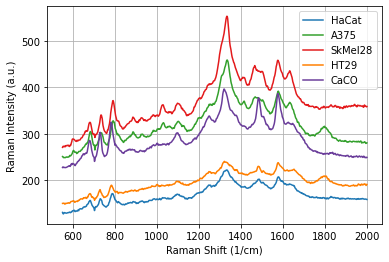

In [4]:
###
kols_ = sns.color_palette('Paired')

##
plt.plot(inverse_wavelenght, xx1.mean(axis= 0), label= 'HaCat', color= kols_[1])
plt.plot(inverse_wavelenght, xx2.mean(axis= 0), label= 'A375', color= kols_[3])
plt.plot(inverse_wavelenght, xx3.mean(axis= 0), label= 'SkMel28', color= kols_[5])
plt.plot(inverse_wavelenght, xx4.mean(axis= 0), label= 'HT29', color= kols_[7])
plt.plot(inverse_wavelenght, xx5.mean(axis= 0), label= 'CaCO', color= kols_[9])
plt.grid(True)
plt.xlabel('Raman Shift (1/cm)')
plt.ylabel('Raman Intensity (a.u.)')
plt.legend()
plt.show()

**** **** **** HaCat-A375 **** **** ****
HaCat-A375AUC 0.99 ± 0.0
*** *** *** ***


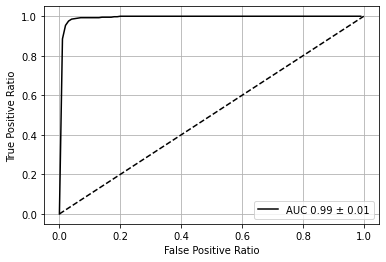

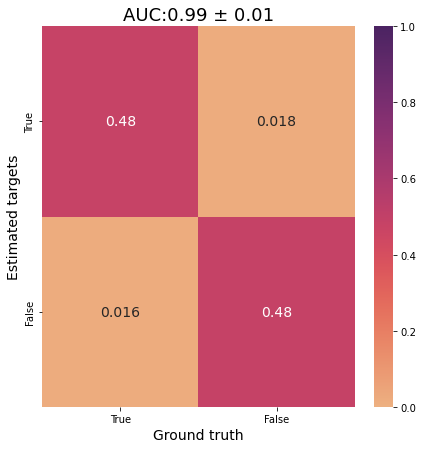

**** **** **** HaCat-SkMel28 **** **** ****
HaCat-SkMel28AUC 0.99 ± 0.0
*** *** *** ***


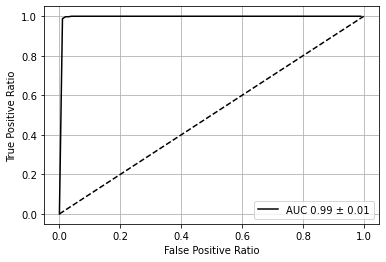

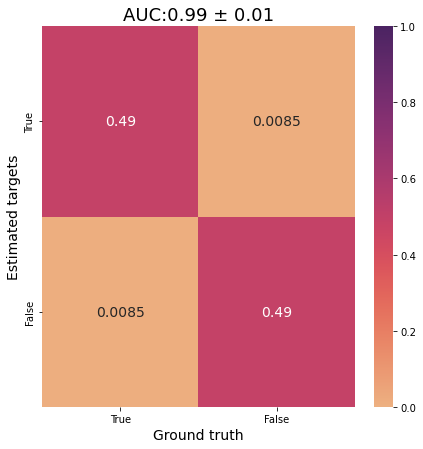

**** **** **** HaCat-HT29 **** **** ****
HaCat-HT29AUC 0.76 ± 0.01
*** *** *** ***


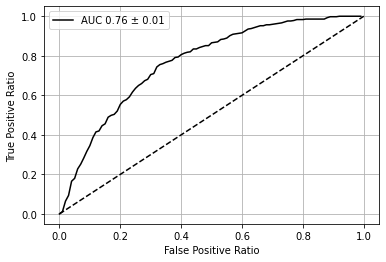

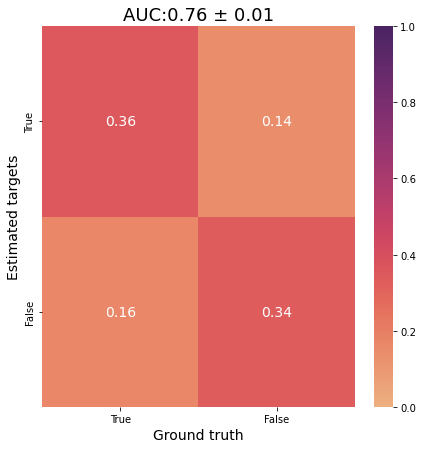

**** **** **** HaCat-CaCO **** **** ****
HaCat-CaCOAUC 0.99 ± 0.0
*** *** *** ***


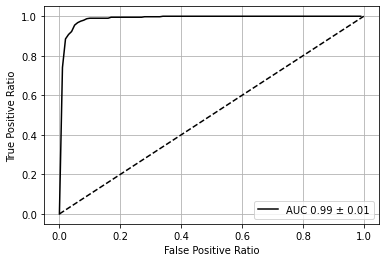

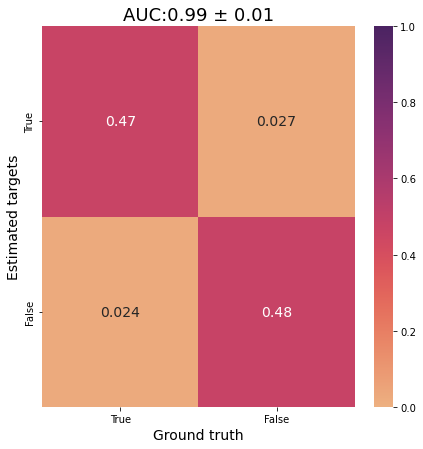

**** **** **** A375-SkMel28 **** **** ****
A375-SkMel28AUC 0.74 ± 0.01
*** *** *** ***


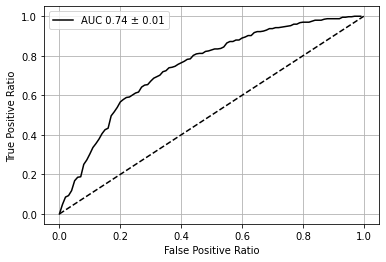

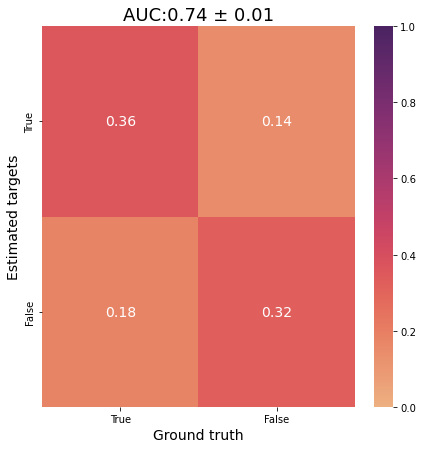

**** **** **** CaCO-HT29 **** **** ****
CaCO-HT29AUC 0.97 ± 0.0
*** *** *** ***


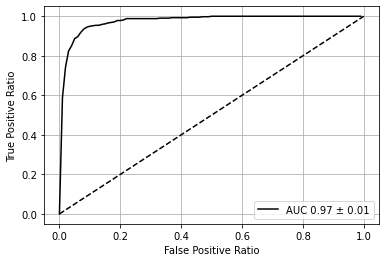

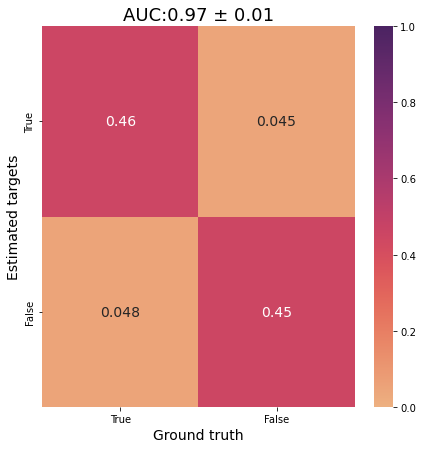

In [5]:
def one_encoding_mean(x0, x1, label):
    
    cod = label
    
    ### get data
    XX = np.vstack([x0.mean(axis= 1).reshape(-1, 1), x1.mean(axis= 1).reshape(-1, 1)])
    YY = np.hstack([np.zeros(x0.shape[0]), np.ones(x1.shape[0])])
    
    #
    auc_box = []
    conf_matrix = []
    roc_box = []
    
    kfold = KFold(5, shuffle=True, random_state=32)
    for index_train, index_test in kfold.split(XX):
        Xtrain, Xtest = XX[index_train], XX[index_test]
        Ytrain, Ytest = YY[index_train], YY[index_test]
        ### fitting of the model
        lr_clf = LogisticRegression(penalty='l2', C= 1e1, fit_intercept=True)
        lr_clf.fit(Xtrain, Ytrain)
        Ypred = lr_clf.predict_proba(Xtest)[:, 1]
        auc_ = np.minimum(.99, roc_auc_score(y_true= Ytest, y_score= Ypred.ravel()))
        auc_box.append(auc_)
        ### ### ### ###
        mtx_ = confusion_matrix(y_pred=lr_clf.predict(Xtest), y_true= Ytest, normalize='all')
        conf_matrix.append(mtx_)
        ###
        fpr, tpr, _ = roc_curve(y_score=Ypred, y_true= Ytest)
        roc_box.append([fpr, tpr, auc_])
    
    ###results
    print('**** **** ****', label, '**** **** ****')
    print(label+'AUC', np.mean(auc_box).round(2),'±', sem(auc_box).round(2))
    print('*** *** *** ***')
    
    #### #### #### #### #### ####
    ###prendi la curva roc media
    myrocs = []
    aucs = []
    for item in roc_box:
        fpr_, tpr_, auc_ = item
        xx = np.clip(roc_box[0][0], a_min=1e-10, a_max=1-1e-10)
        yy = np.clip(roc_box[0][1], a_min=1e-10, a_max=1-1e-10)
        myroc = np.interp(x = np.arange(0, 1, 1e-2), 
                          xp= xx, 
                          fp= yy, 
                          left=0, right=1)

        myrocs.append(myroc)
        aucs.append(auc_)

    c_ = str(np.minimum(99e-2, np.mean(aucs).round(2))) + ' ± '+str(np.maximum(1e-2, sem(aucs).round(2)))
    plt.plot(np.arange(0, 1, 1e-2), myroc, c= 'black', label= 'AUC '+c_)
    plt.plot([0, 1], [0, 1], ls= '--', c= 'black')
    plt.grid(True)
    plt.ylabel('True Positive Ratio')
    plt.xlabel('False Positive Ratio')
    plt.savefig('imgs_diana_sep2022_LR_onehotencode/'+type_chunk+cod+'_AUC_ROC_one_enc.png', bbox_inches='tight')
    plt.legend()
    roc_df = pd.DataFrame(np.array([np.arange(0, 1, 1e-2), myroc]).T)
    roc_df.to_csv('/Users/pinguino/Documents/Raman Spectra/imgs_articolo/'+cod+'ROC_LRA_basso.csv', header=False, index=False, index_label=False)
    plt.show()
    
    ### plot Confusion MAtrix
    plt.figure(1, figsize=(7, 7))
    plt.title('AUC:'+c_, fontsize= 18)
    df_ = pd.DataFrame(np.array(conf_matrix).mean(axis= 0), columns=[['True', 'False']])
    df_ = df_.set_index([['True', 'False']])
    sns.heatmap(df_, cmap= 'flare', vmin=0, vmax=1, annot=True, annot_kws={"size": 14})
    plt.xlabel('Ground truth', fontsize= 14)
    plt.ylabel('Estimated targets', fontsize= 14)
    plt.savefig('imgs_diana_sep2022_LR_onehotencode/'+type_chunk+cod+'_ConfMatrix_one_enc.png', bbox_inches='tight')
    plt.show()
    return 

####
one_encoding_mean(xx1, xx2, 'HaCat-A375')
one_encoding_mean(xx1, xx3, 'HaCat-SkMel28')
one_encoding_mean(xx1, xx4, 'HaCat-HT29')
one_encoding_mean(xx1, xx5, 'HaCat-CaCO')
one_encoding_mean(xx2, xx3, 'A375-SkMel28')
one_encoding_mean(xx4, xx5, 'CaCO-HT29')

# Pre-pre screening
- I use the mean value of the chunk (100-500cm^{-1}) as a unique explanatory variable

In [6]:
def report(x1, x2, cod):

    label = cod
    
    ### Internal function
    def prepeare_data_not_equalsized_chunks(X1, X2, raman_knots, raman_shifts= inverse_wavelenght):
        X = np.vstack([X1, X2])
        Y = np.hstack([np.zeros(X1.shape[0]), np.ones(X2.shape[0])])
        #knots are the wavelenghts delimiting the endo of one chunk    
        knots = [np.argmin(np.abs(raman_shifts-item)) for item in raman_knots]
        knots_ = np.hstack([0, np.array(knots), raman_shifts.shape[0]-1])
        input_feats = [X[:, knots_[kk-1]:knots_[kk]].mean(axis= 1) for kk in range(1, knots_.size)]
        #input_feats = [np.average(X[:, knots_[kk-1]:knots_[kk]], 
        #                          weights= hamming(knots_[kk]-knots_[kk-1])/hamming(knots_[kk]-knots_[kk-1]).sum(),
        #                          axis= 1) for kk in range(1, knots_.size)]
        left_edge = [inverse_wavelenght[knots_[kk]].round(0) for kk in range(knots_.size-1)]
        right_edge = [inverse_wavelenght[knots_[kk]].round(0) for kk in range(1, knots_.size)]
        return np.array(input_feats).T, Y, left_edge, right_edge
    
    
    #### #### #### #### ####
    ## call data
    X, Y, left_egde_ticks, right_egde_ticks = prepeare_data_not_equalsized_chunks(x1, x2, 
                                                                                  raman_knots= [640, 700, 760,
                                                                                               860, 1120, 1450,
                                                                                               1600, 1705])
    
    ## Kfold validation (Details)
    nfolds = 10
    kfold = KFold(nfolds, random_state= 32, shuffle=True)

    ################
    #### #### #### Mean Pooling + Importance Relevance
    print('**** **** ****')
    print('Mean pooling and Importance Relevance')
    imp_mean, imp_std, AUCs = [], [], []
    box_auc = []
    roc_box = []
    conf_matrix= []
    for index_train, index_test in kfold.split(X):
        Xtrain, Xtest = X[index_train], X[index_test]
        Ytrain, Ytest = Y[index_train], Y[index_test]
        ### fitting of the model
        lr_clf = LogisticRegression(penalty='l2', C= 1)
        lr_clf.fit(Xtrain, Ytrain)
        Ypred = lr_clf.predict_proba(Xtest)[:, 1]
        auc_ = np.minimum(.99, roc_auc_score(y_true= Ytest, y_score= Ypred.ravel()).round(2))
        #print('ATTEMPT', n0, 'AUC:', auc_.round(2))
        box_auc.append(auc_)
        fpr, tpr, _ = roc_curve(y_score=Ypred, y_true= Ytest)
        mtx_ = confusion_matrix(y_pred=lr_clf.predict(Xtest), y_true= Ytest, normalize='all')
        conf_matrix.append(mtx_)
        roc_box.append([fpr, tpr, auc_])

        ### ### ###
        r = permutation_importance(lr_clf, Xtest, Ytest,
                                   scoring='roc_auc',
                                   n_repeats=30,
                                    random_state=0)

        imp_mean.append(r['importances_mean'])
        imp_std.append(r['importances_std'])
    
    
    imp_mean = np.vstack(imp_mean).mean(axis= 0).round(2)
    imp_std = np.vstack(imp_std).mean(axis= 0).round(2)
    band_ticks = [str(left_egde_ticks[kk])+'-'+str(right_egde_ticks[kk]) for kk in range(len(right_egde_ticks))]
    plt.errorbar(x= np.arange(0, imp_mean.shape[0], 1), y= imp_mean, 
                 yerr= imp_std, marker= 'D', c= 'black', ls= '--')
    plt.xlabel('Band [cm^-1]')
    plt.ylabel('importance_mean')
    plt.xticks(list(np.arange(0, imp_mean.shape[0], 1)), band_ticks, rotation= 90)
    plt.grid(True)
    plt.savefig('imgs_diana_sep2022_LR_averagepooling/'+type_chunk+cod+'_importance_relevance_averagepooling.png', bbox_inches='tight')
    plt.show()
    
    #### #### #### #### #### ####
    ###prendi la curva roc media
    myrocs = []
    aucs = []
    for item in roc_box:
        fpr_, tpr_, auc_ = item
        xx = np.clip(roc_box[0][0], a_min=1e-10, a_max=1-1e-10)
        yy = np.clip(roc_box[0][1], a_min=1e-10, a_max=1-1e-10)
        myroc = np.interp(x = np.arange(0, 1, 1e-2), 
                          xp= xx, 
                          fp= yy, 
                          left=0, right=1)

        myrocs.append(myroc)
        aucs.append(auc_)

    c_ = str(np.minimum(99e-2, np.mean(aucs).round(2))) + ' ± '+str(np.maximum(1e-2, sem(aucs).round(2)))
    plt.plot(np.arange(0, 1, 1e-2), myroc, c= 'black', label= 'AUC '+c_)
    plt.plot([0, 1], [0, 1], ls= '--', c= 'black')
    plt.grid(True)
    plt.ylabel('True Positive Ratio')
    plt.xlabel('False Positive Ratio')
    plt.savefig('imgs_diana_sep2022_LR_averagepooling/'+type_chunk+cod+'_AUC_ROC_averagepooling.png', bbox_inches='tight')
    plt.legend()
    plt.show()
    
    ### plot Confusion MAtrix
    plt.figure(1, figsize=(7, 7))
    plt.title('AUC:'+c_, fontsize= 18)
    df_ = pd.DataFrame(np.array(conf_matrix).mean(axis= 0), columns=[['True', 'False']])
    df_ = df_.set_index([['True', 'False']])
    sns.heatmap(df_, cmap= 'flare', vmin=0, vmax=1, annot=True, annot_kws={"size": 14})
    plt.xlabel('Ground truth', fontsize= 14)
    plt.ylabel('Estimated targets', fontsize= 14)
    plt.savefig('imgs_diana_sep2022_LR_averagepooling/'+type_chunk+cod+'Conf_Matrix_averagepooling.png', bbox_inches='tight')
    plt.show()
    return 

# HaCat_A375

**** **** ****
Mean pooling and Importance Relevance


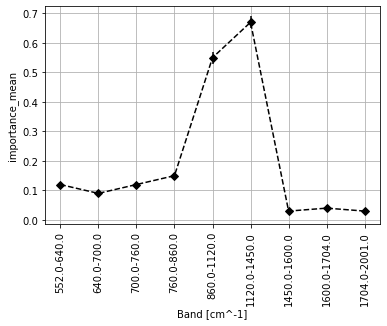

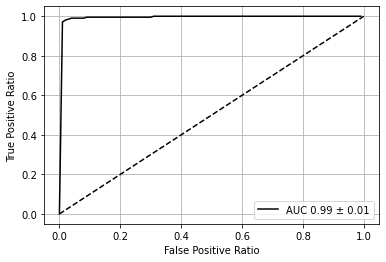

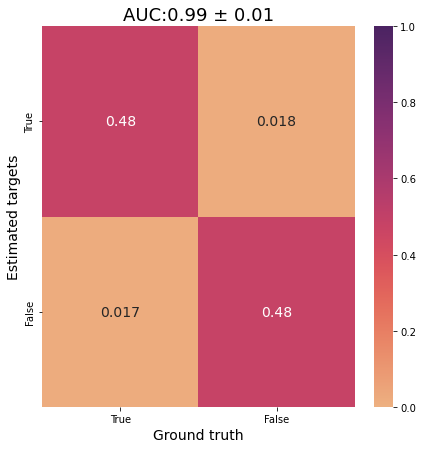

In [7]:
report(xx1, xx2, cod= 'HaCat_A375')

# HaCat_SkMel28

**** **** ****
Mean pooling and Importance Relevance


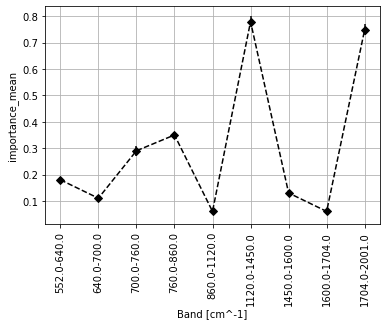

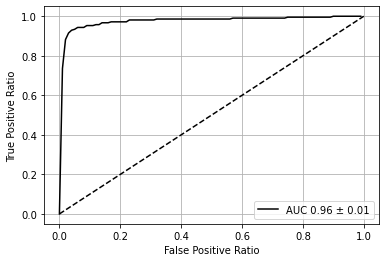

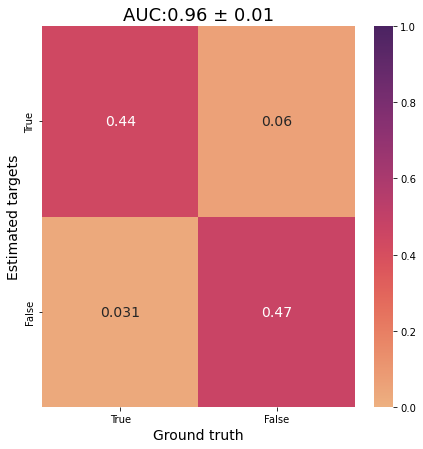

In [8]:
report(xx1, xx3, cod= 'HaCat_SkMel28') 

# A375-SkMel28

**** **** ****
Mean pooling and Importance Relevance


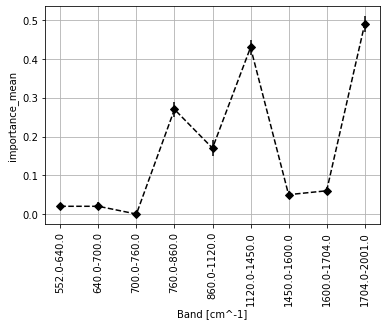

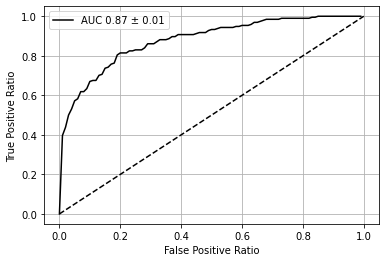

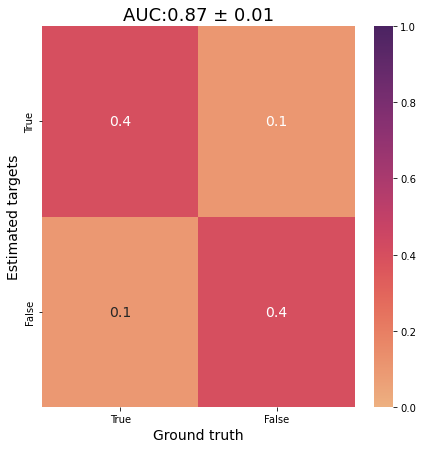

In [9]:
report(xx2, xx3, cod= 'A375-SkMel28')

# HaCat-HT29

**** **** ****
Mean pooling and Importance Relevance


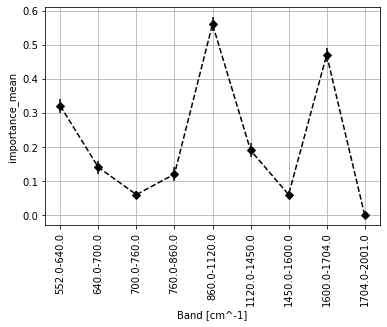

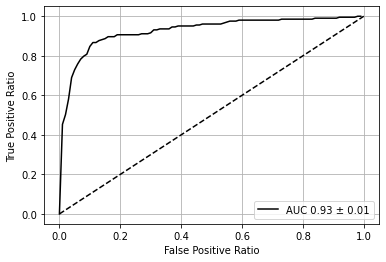

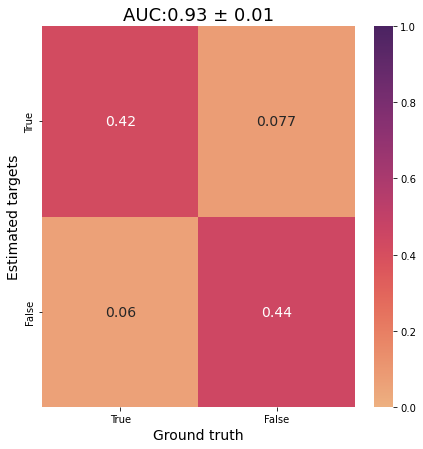

In [10]:
report(xx1, xx4, cod= 'HaCat-HT29')

# HaCat-CaCO

**** **** ****
Mean pooling and Importance Relevance


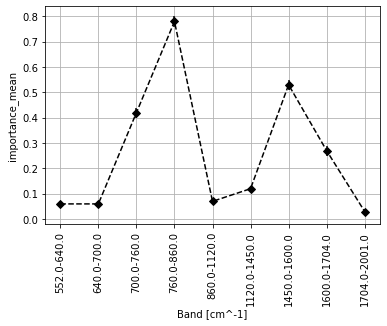

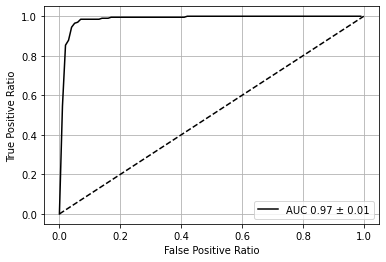

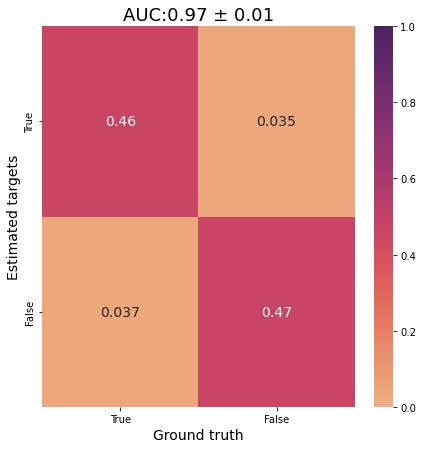

In [11]:
report(xx1, xx5, cod= 'HaCat-CaCO')

# HT29-CaCO

**** **** ****
Mean pooling and Importance Relevance


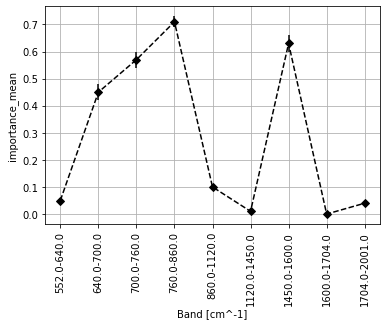

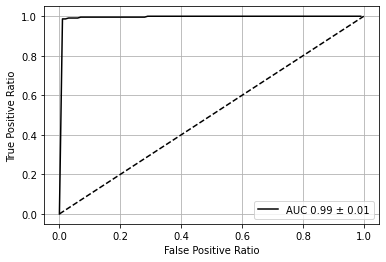

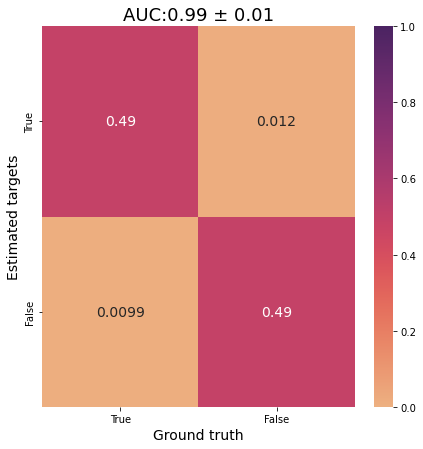

In [12]:
report(xx4, xx5, cod= 'HT29-CaCO')